# 6. 사람의 지도 없이 학습하는 오토인코더

## 6.0. 요약

### 6.0.1. 지난장
지난 5장에서는 3,4장을 바탕으로 학습한 신경망의 기초를 활용하여, 주로 영상이나 이미지를 다루는 문제에서 실제로 물체를 인식하는 방식을 활용한 합성곱신경망(Convolutional Neural Network,CNN)에 대해서 다루어보았다.

그리고 기초적인 Convolution, Pooling, 일반 신경망으로 구성된 CNN모델 뿐 아니라, 더 높은 성능을 위해 고안된 신경망 모델들 중 2015년에 등장한 ResNet에 대해서 알아보고 이를 실제로 구현해보았다.

### 6.0.2. 이번장
이번 6장에서는 앞서 살펴본 레이블, $y$ 값이 주어지고 $\hat{y}$ 신경망과 달리, 각 element에 대해 label 값이 주어지지 않는 데이터에 대해 신경망을 생성하려고 한다. 우리는 이러한 목적을 위한 학습을 '비지도학습'이라고 한다. 

비지도학습에서는 지도학습과는 달리 레이블을 통해 오차를 계산할 수 없는데, 그렇다면, 어떻게 비지도학습에서 오차를 계산하여 학습이 이루어지게 할 수 있을까? 그래서, 입력 $x$값을 활용하여 신경망을 통해 출력된 값과 오차를 비교함으로써 학습을 진행하는 방식을 활용한 신경망인 오토인코더를 활용하는 것이다.

이번 장에서는 오토인코더에 대해서 알아보고, 오토인코더를 활용한 이미지 복원과 같은 실습을 진행하려고 한다.

## 6.1. 오토인코더 기초
오토인코더는 요약에서 언급한 것과 같이, 레이블이 없는 데이터에 대해 입력값 $x$을 가지고 신경망을 거친 출력값 $x$을 활용하여 오차를 계산하여 학습을 진행하는 신경망이다. 오토인코더는 크게보면 인코더와 디코더로 이루어진 신경망이다. 인코더를 통해 주어진 입력값을 대표할 수 있는 잠재요인 값을 추출하고, 디코더를 통해 이를 원상태로 복원한다. 추출과 복원과정에 있어서 정보의 소실이 일어나지만 복원오차(정보손실값)을 활용하여 학습을 진행하게 된다.

그런데, 오토인코더의 인코더는 일반적으로 이미지를 압축하는 ZIP과는 다르다. 왜냐하면 오토인코더가 차원을 축소하는 은닉층들을 거칠 수록 덜 중요한 정보들을 버리는 과정으로 인해 잠재요인을 추출하기 때문이다.

따라서, 오토인코더는 주로 복잡헌 비선형 데이터의 차원을 줄이는 용도로 사용된다. 그리고, 비정상 거래 검출, 데이터 시각화와 복원, 의미추출, 이미지 검색등에도 사용된다.

## 6.2. 오토인코더로 이미지의 특징 추출하기

In [1]:
import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np

from tqdm import tqdm_notebook

In [2]:
EPOCH = 10
BATCH_SIZE = 64
USE_CUDA = torch.cuda.is_available()
DEVICE = "cuda" if USE_CUDA else "cpu"
print("Using Device: {}".format(DEVICE))

Using Device: cpu


In [3]:
train_transform = transforms.Compose([
    transforms.ToTensor()
])

In [4]:
train_dataset = datasets.FashionMNIST(
    root = './data/',
    train = True,
#     download = True,
    download = False,
    transform = train_transform
)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size = BATCH_SIZE,
    shuffle =True
)

우리가 실습에 사용할 간단한 오토인코더에 대해서 살펴보자.

오토인코더는 먼저 언급한 것과 같이 인코더와 디코더로 구성된다. 따라서 인코더부와 디코더부로 나누었다. 그리고 인코더를 통해 3개의 잠재요인 값들을 반환하도록 설계하였고, 이 잠재요인들을 활용하여 유사한 입력값들이 모여서 분포하는지 살펴본다. 그리고 디코더는 출력을 Sigmoid 함수를 활용하여 0에서 1사이의 값들을 가지도록 설계했다.

In [5]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        
        return encoded, decoded

In [6]:
if USE_CUDA:
    autoencoder = AutoEncoder().to(DEVICE)
else:
    autoencoder = AutoEncoder()
    
optimizer = optim.Adam(autoencoder.parameters(), lr=0.005)
criterion = nn.MSELoss()

파이토치에서는 학습에서 가중치 추정을 위해 사용되는 최적화 알고리즘들을 제공하고 있다. 따라서, 최적화 알고리즘들에 대해서 더 자세히 알고 싶다면 아래 링크의 강의를 통해 학습하자

* Gradient Descent With Momentum: https://www.youtube.com/watch?v=k8fTYJPd3_I
* RMSProp: https://www.youtube.com/watch?v=_e-LFe_igno
* Adam Optimization Algorithm: https://www.youtube.com/watch?v=JXQT_vxqwIs

* 가중치를 업데이트하는 최적화 방법들: http://aikorea.org/cs231n/neural-networks-3/

In [7]:
view_data = train_dataset.data[:5].view(-1, 28*28)
view_data = view_data.type(torch.FloatTensor)/255.

In [8]:
def train(autoencoder, train_loader):
    autoencoder.train()
    
    for batch_num, (inputs, labels) in enumerate(train_loader):
        if USE_CUDA:
            inputs = inputs.view(-1,28*28).to(DEVICE)
            labels = labels.to(DEVICE)
        else:
            inputs = inputs.view(-1,28*28)
            
        autoencoder.zero_grad()
        
        encoded, decoded = autoencoder(inputs)
        loss = criterion(decoded, inputs)
        loss.backward()
        optimizer.step()

In [9]:
for epoch in tqdm_notebook(range(1,EPOCH+1)):
    train(autoencoder, train_loader)

In [10]:
encoded_view_data, decoded_view_data = autoencoder(view_data)

Text(0.5,0.98,'AutoEncoder Restored Image by 5 epochs')

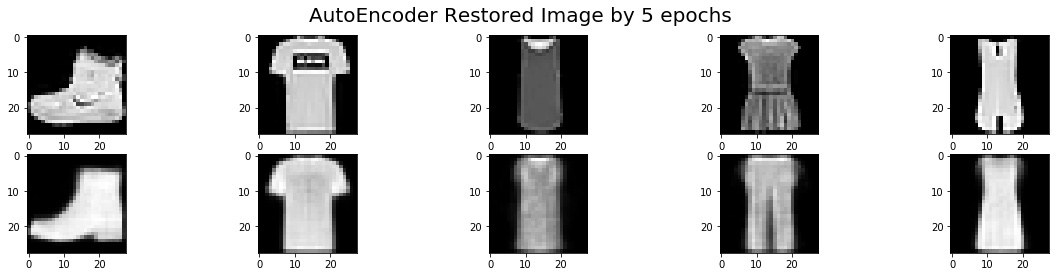

In [11]:
fig, axes = plt.subplots(2,5,figsize=[20,4])

for i in range(10):
    row = i // 5
    col = i % 5
    
    if row == 0:
        img = np.reshape(view_data.data.numpy()[col],(28,28))
        axes[row][col].imshow(img, cmap="gray")
    elif row == 1:
        img = np.reshape(decoded_view_data.data.numpy()[col],(28,28))
        axes[row][col].imshow(img, cmap="gray")

plt.suptitle("AutoEncoder Restored Image by 5 epochs",size=20)

## 6.2.2. 잠재 변수 들여다보기

앞서 AutoEncoder 사용 시, Encoder를 거치게 되면 input으로 주어졌던 데이터의 주요 요소만을 담은 잠재요인을 추출할 수 있다고 했다. 이번 장에서는 Encoder를 통해 추출된 잠재요인만으로 패션 아이템을 유의미하게 3차원 공간내에서 분류를 할 수 있는지에 대해서 알아보자

In [14]:
view_data = train_dataset.data[:200].view(-1, 28*28)
view_data = view_data.type(torch.FloatTensor)/255.


if USE_CUDA:
    test_x = view_data.to(DEVICE)
else:
    test_x = view_data
    
encoded_data, decoded_data = autoencoder(test_x)

if USE_CUDA:
    encoded_data = encoded_data.to("CPU")

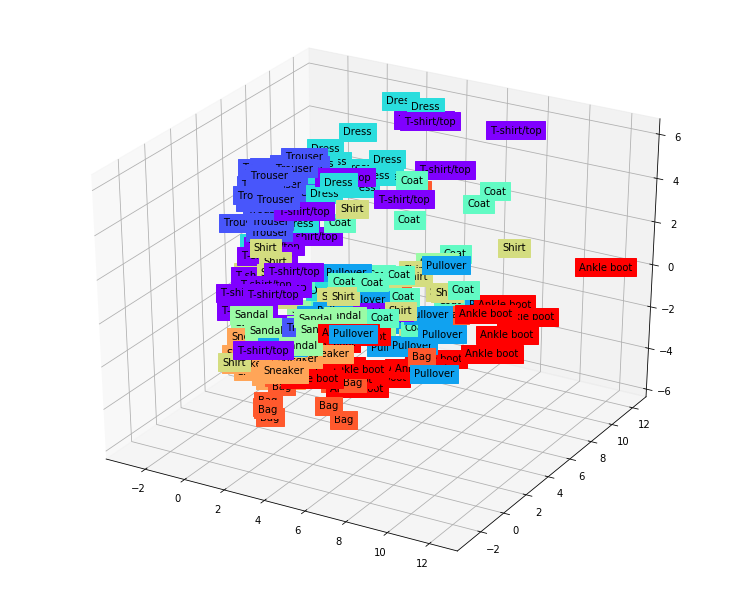

In [33]:
labels = ["T-shirt/top", 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
label_dict = {idx:label for idx, label in enumerate(labels)}

fig = plt.figure(figsize=[10,8])
ax = Axes3D(fig)

X = encoded_data[:,0].data.numpy()
Y = encoded_data[:,1].data.numpy()
Z = encoded_data[:,2].data.numpy()

labels = train_dataset.targets[:200].data.numpy()

for x,y,z,s in zip(X,Y, Z, labels):
    name = label_dict[s]
    color = cm.rainbow(int(255*s/9))
    ax.text(x,y,z,name, backgroundcolor=color)
    ax.set_xlim(X.min(), X.max())
    ax.set_ylim(X.min(), X.max())
    ax.set_zlim(Z.min(), Z.max())
    
plt.show()

## 6.3. 오토인코더로 망가진 이미지 복원하기

잡음 제거 오토인코더(denoising autoencoder)를 활용하여 이미지를 복원해보자. 오토인코더는 인코더를 거치며 입력값의 특징을 잘 반영하는 잠재요인으로 압축을 진행합니다. 기본적인 오토인코더와 동일하지만 인코더에서 학습 진행시 노이즈를 더해줌으로써 덜 중요한 데이터를 제거하는 방식으로 진행됩니다.

In [34]:
def add_noise(img):
    noise = torch.randn(img.size()) * 0.2
    noisy_img = img + noise
    return noisy_img

In [36]:
def train(autoencoder, train_loader):
    autoencoder.train()
    avg_loss = 0
    
    for inputs, labels in train_loader:
        if USE_CUDA:
            inputs = inputs.view(-1,28*28).to(DEVICE)
            labels = labels.to(DEVICE)
        else:
            inputs = inputs.view(-1,28*28)
            
        inputs = add_noise(inputs)
        
        autoencoder.zero_grad()
        encoded, decoded = autoencoder(inputs)
        
        loss = criterion(inputs,decoded)
        loss.backward()
        optimizer.step()
        
        avg_loss += loss.item()
        
    return avg_loss / len(train_loader)

In [38]:
for epoch in range(EPOCH):
    avg_loss = train(autoencoder,train_loader)
    print("EPOCH: {}; loss: {}".format(epoch, avg_loss))

EPOCH: 0; loss: 0.06267540451528421
EPOCH: 1; loss: 0.06217214391668087
EPOCH: 2; loss: 0.062052069565475876
EPOCH: 3; loss: 0.06190195216584816
EPOCH: 4; loss: 0.061870987529058195
EPOCH: 5; loss: 0.06180019562305418
EPOCH: 6; loss: 0.061762502115132456
EPOCH: 7; loss: 0.06168442270331291
EPOCH: 8; loss: 0.06178589701366577
EPOCH: 9; loss: 0.06156712702946114


In [39]:
test_dataset = datasets.FashionMNIST(
    root = './data/',
    train = False,
#     download = True,
    download = False,
    transform = train_transform
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size = BATCH_SIZE,
    shuffle =True
)

In [42]:
sample_data = test_dataset.data[0].view(-1,28*28)
sample_data = sample_data.type(torch.FloatTensor)/255.

origin_x = sample_data[0]
if USE_CUDA:
    noisy_x = add_noise(origin_x).to(DEVICE)
else:
    noisy_x = add_noise(origin_x)
    
encoded_x, decoded_x = autoencoder(noisy_x)

Text(0.5,0.95,'Denoisying AutoEncoder')

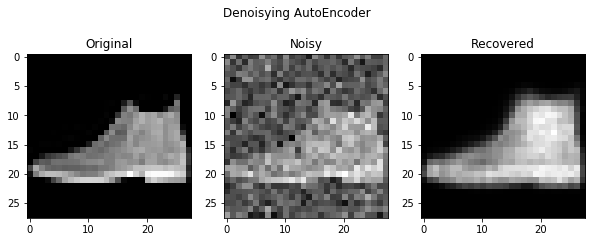

In [58]:
origin_img = origin_x.view(28,28).data.numpy()
noisy_img = noisy_x.view(28,28).data.numpy()
decoded_img = decoded_x.view(28,28).data.numpy()

fig,axes = plt.subplots(1,3, figsize=[10,4])

axes[0].set_title('Original')
axes[0].imshow(origin_img, cmap="gray")
axes[1].set_title('Noisy')
axes[1].imshow(noisy_img, cmap="gray")
axes[2].set_title('Recovered')
axes[2].imshow(decoded_img, cmap="gray")

plt.suptitle("Denoisying AutoEncoder", y=0.95)